# **Acquiring dataset and exploratory data analysis**

In [1]:
# Importing dependencies
import numpy as np
import PIL
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
import tensorflow as tf
from tensorflow.keras import layers # False warning
import csv
import cv2
import pandas as pd

!pip install silence_tensorflow
import silence_tensorflow.auto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4475 sha256=d268c103a19e91d4903d78e655f9a6c89d94a0c7869fa095817d8887c64d628a
  Stored in directory: /root/.cache/pip/wheels/d6/ec/29/1ed23ae577b310931b534a6da0aa3adc169deef9a8ef10bd26
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5651 sha256=8eef2bb1491909ddd7ddb52baad4251fe7c9c5c5c34a432e3c631efe0e4ac0b5
  Stored in directory: /root/.cache/pip/wheels/7c/a1/b1/9662c79502c353ff7e71c36f84846acd623cbcbe3f7255f5d5
Successfully built silence_tensorflow support_developer


In [2]:
# Downloading dataset
!gdown "https://drive.google.com/uc?id=1fSu9gWbu4MOf7N9u7ir9D5Z6xbKJJnZp&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1fSu9gWbu4MOf7N9u7ir9D5Z6xbKJJnZp&confirm=t
To: /content/GTSRB_dataset.zip
100% 642M/642M [00:19<00:00, 33.7MB/s]


In [3]:
# Extracting dataset
with ZipFile("GTSRB_dataset.zip", 'r') as zip:
    print('Extracting all the files now...')
    zip.extractall('/content/GTSRB_dataset')
    zip.close()
    print('Extraction done!')

Extracting all the files now...
Extraction done!


In [6]:
# Modifying class names for actual labels
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

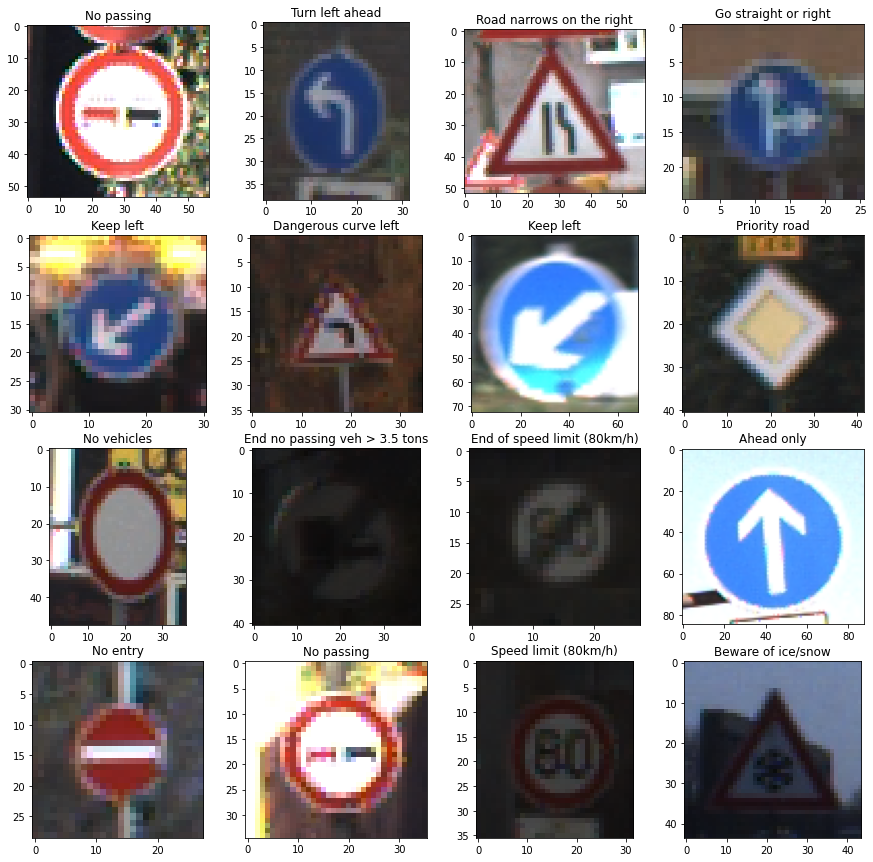

In [7]:
# Showing sample images
np.random.seed(123)
fig = plt.figure(figsize=(15, 15))

for i in range(1, 4*4 +1):
    rand_class = np.random.randint(42)
    class_numbers = os.listdir('/content/GTSRB_dataset/Train')
    rand_folder = os.listdir('/content/GTSRB_dataset/Train/' + class_numbers[rand_class])
    ax = fig.add_subplot(4, 4, i)
    img = np.array(PIL.Image.open('/content/GTSRB_dataset/Train/' + str(class_numbers[rand_class]) + '/' + np.random.choice(rand_folder)))
    plt.imshow(img)
    ax.set_title(str(classes[int(class_numbers[rand_class])]))
plt.show()

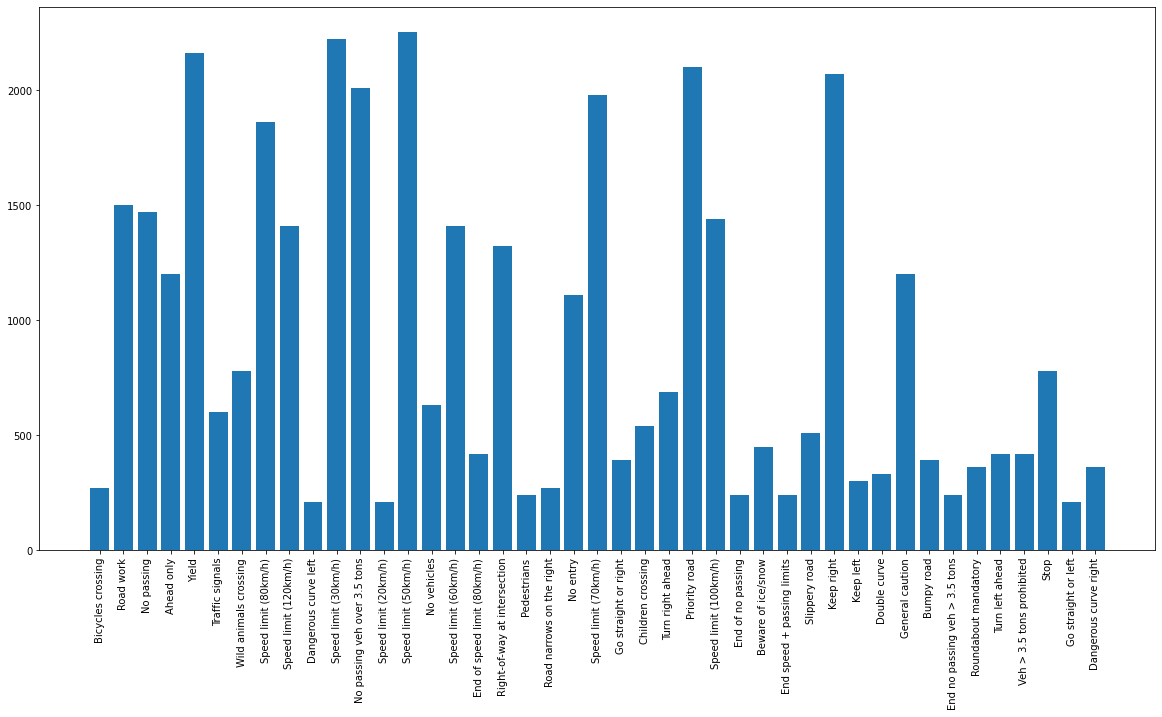

In [8]:
# Showing the distribution of the different classes
TRAIN_SET_PATH = '/content/GTSRB_dataset/Train'
folders = os.listdir(TRAIN_SET_PATH)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(TRAIN_SET_PATH + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Plotting the number of images in each class
plt.figure(figsize=(20,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [9]:
# Defining parameters for data loading
TRAIN_BATCH_SIZE = 64
IMG_HEIGHT = 40
IMG_WIDTH = 40

VAL_BATCH_SIZE = 64
VAL_SPLIT_RATIO = 0.2

In [10]:
# Loading training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_SET_PATH,
    validation_split = VAL_SPLIT_RATIO,
    subset = "training",
    seed=123,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = (TRAIN_BATCH_SIZE)
)

# Loading training validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_SET_PATH,
    validation_split = VAL_SPLIT_RATIO,
    subset = "validation",
    seed=123,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = (VAL_BATCH_SIZE)
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


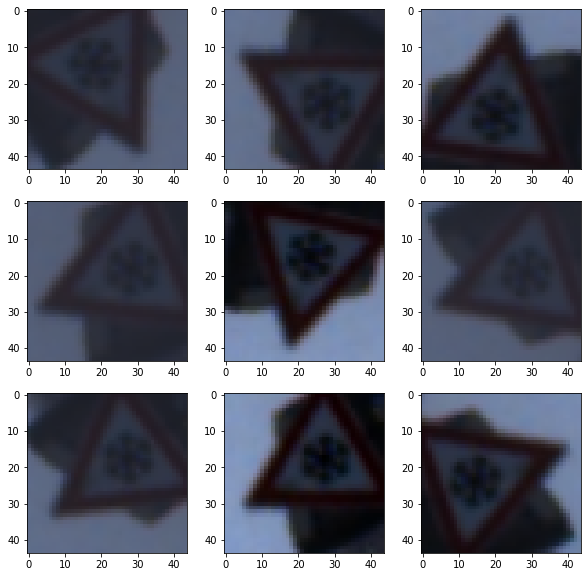

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=(-0.2, -0.3)),
    layers.RandomContrast(factor=0.5)
])

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(tf.expand_dims(img,0))
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0]/255)

In [12]:
# Creating the model
num_classes = len(train_ds.class_names)
print(num_classes)

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

43


In [13]:
# Showing model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 40, 40, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)       

In [14]:
# Training the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

491/491 [==============================] - 78s 157ms/step - loss: 1.6854 - accuracy: 0.5246 - val_loss: 0.5892 - val_accuracy: 0.8280


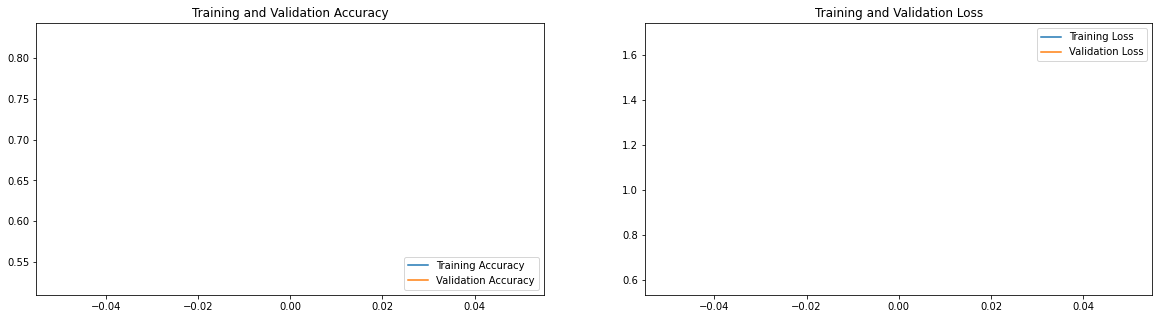

In [15]:
# Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# Predictions on the test set
TEST_SET_PATH = '/content/GTSRB_dataset'
predictions = []
# reading the CSV file
test_csv = pd.read_csv('/content/GTSRB_dataset/Test.csv')
test_img_paths = test_csv["Path"].values
test_labels = test_csv["ClassId"].values
cnt = 0
ok_pred =0

for test_img_path in test_img_paths:
  test_img = tf.keras.utils.load_img(TEST_SET_PATH + '/' + test_img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img_array = tf.keras.utils.img_to_array(test_img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  curr_pred = model.predict(img_array, verbose = 0)
  score = tf.nn.softmax(curr_pred[0])
  class_pred = int(train_ds.class_names[np.argmax(score)])
  correct_label = int(test_labels[cnt])
  cnt+=1
  if class_pred == correct_label:
    ok_pred +=1
  if cnt == 101:
    break
acc = (ok_pred/cnt)*100
print("Accuracy on the test set: {:.5f}%" .format(acc))
#print("Predicted class: ", classes[int(train_ds.class_names[np.argmax(score)])])
#print("Correct label: ", test_labels[cnt])

Accuracy on the test set: 72.27723%


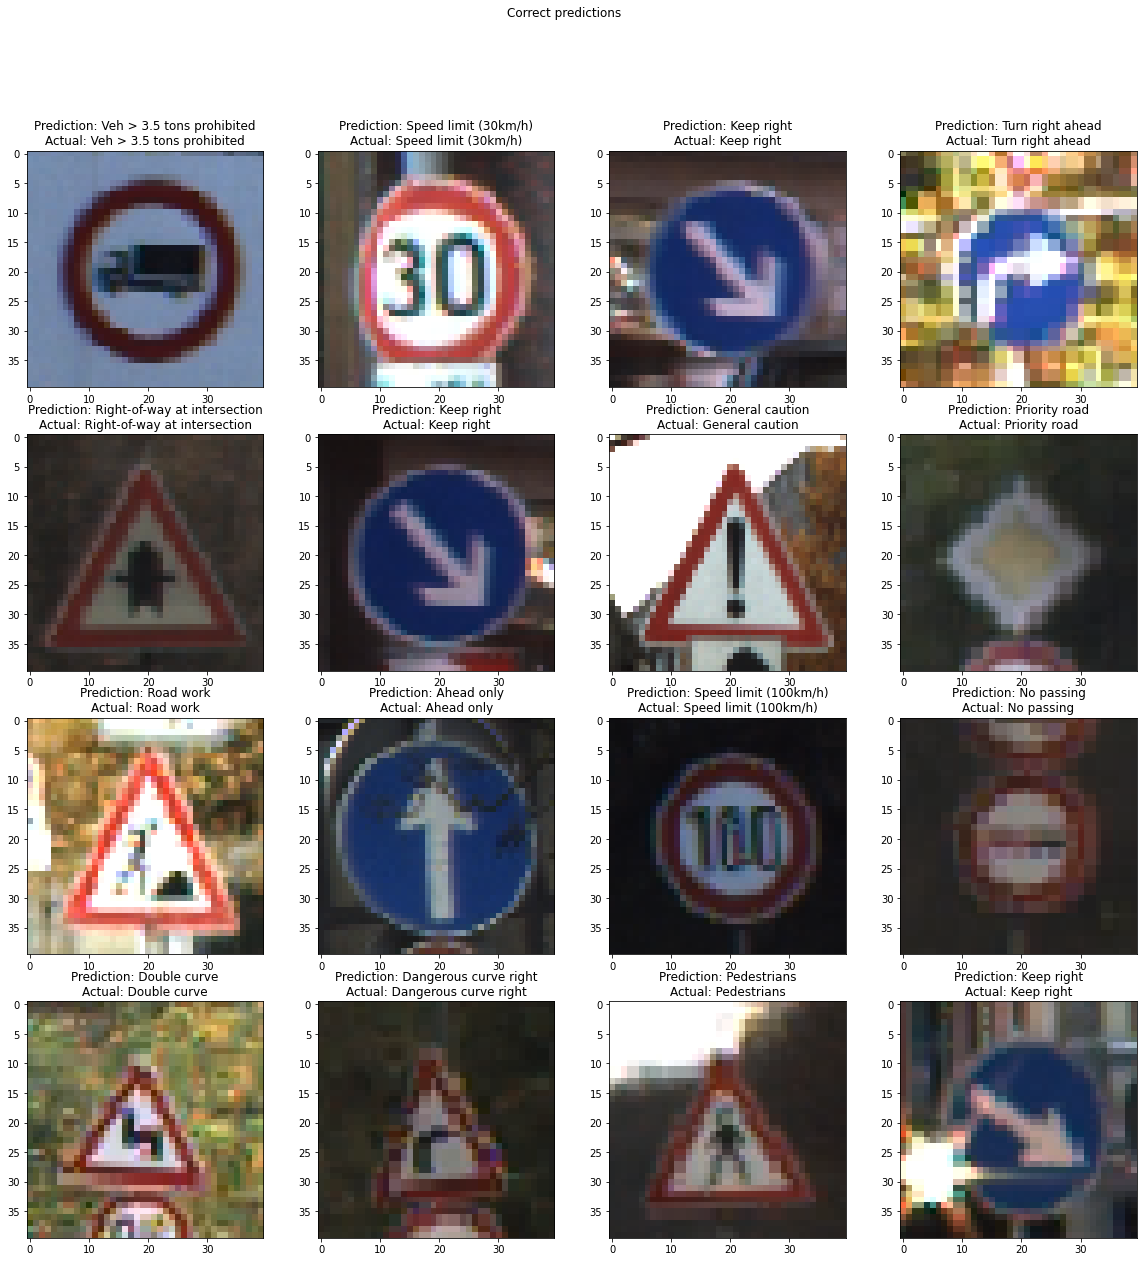

In [50]:
# Showing inference on random test images
fig_correct = plt.figure(figsize=(20, 20))
fig_correct.suptitle("Correct predictions")
plt_cnt = 1
label_cnt = 0

for test_img_path in test_img_paths:
  test_img = tf.keras.utils.load_img(TEST_SET_PATH + '/' + test_img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img_array = tf.keras.utils.img_to_array(test_img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  curr_pred = model.predict(img_array, verbose = 0)
  score = tf.nn.softmax(curr_pred[0])
  class_pred = int(train_ds.class_names[np.argmax(score)])
  correct_label = int(test_labels[label_cnt])
  label_cnt +=1
  if class_pred == correct_label:
    ax = fig_correct.add_subplot(4, 4, plt_cnt)
    ax.set_title(str("Prediction: {}\nActual: {}".format(classes[class_pred],classes[correct_label])))
    plt.imshow(test_img)
    plt_cnt += 1
  if plt_cnt == 17:
    break
plt.show()

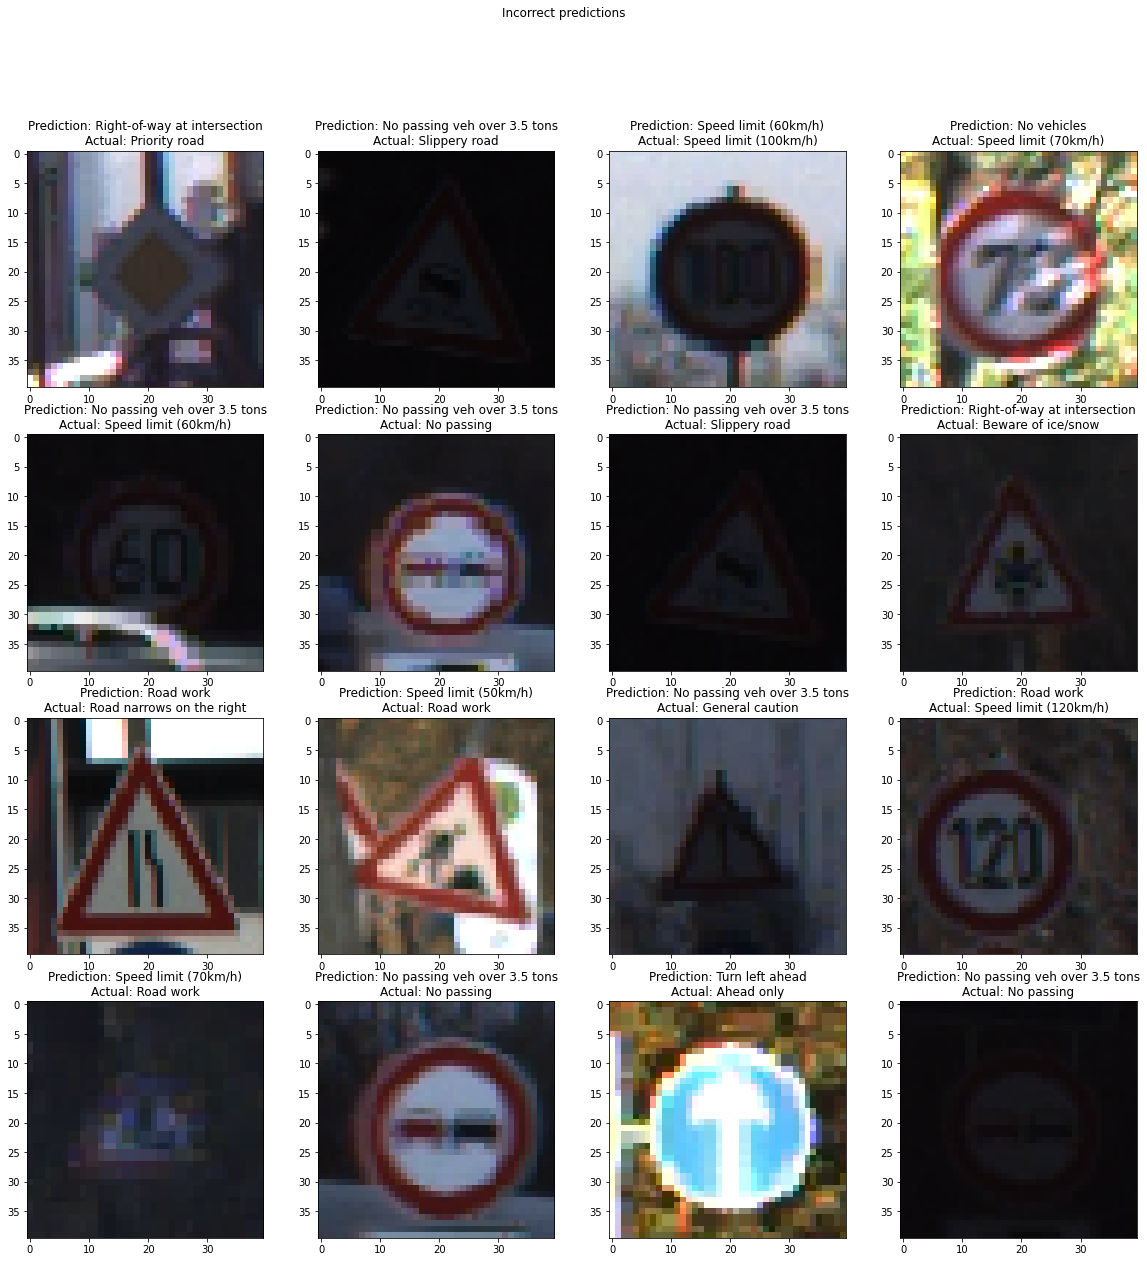

In [51]:
# False predictions
fig_false = plt.figure(figsize=(20, 20))
fig_false.suptitle("Incorrect predictions")
plt_cnt = 1
label_cnt = 0

for test_img_path in test_img_paths:
  test_img = tf.keras.utils.load_img(TEST_SET_PATH + '/' + test_img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img_array = tf.keras.utils.img_to_array(test_img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  curr_pred = model.predict(img_array, verbose = 0)
  score = tf.nn.softmax(curr_pred[0])
  class_pred = int(train_ds.class_names[np.argmax(score)])
  correct_label = int(test_labels[label_cnt])
  label_cnt +=1
  if class_pred != correct_label:
    ax = fig_false.add_subplot(4, 4, plt_cnt)
    ax.set_title(str("Prediction: {}\nActual: {}".format(classes[class_pred],classes[correct_label])))
    plt.imshow(test_img)
    plt_cnt +=1
    if plt_cnt == 16+1:
      break
plt.show()